In [1]:
import pandas as pd
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile
import matplotlib.pyplot as plt


In [2]:
url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

## Statistique desc

In [3]:
EEC_2019.head()

,ANNEE,TRIM,CATAU2010R,METRODOM,TYPMEN7,AGE3,AGE5,COURED,ENFRED,NFRRED,...,DIP11,CSTOTPRM,IDENTM,EXTRIAN,EMPNBH,HREC,HHCE,HPLUSA,JOURTR,NBTOTE
0,2019,1,1,1,1,50,60,2,2,1.0,...,70.0,86.0,1,107.749722,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,2,1,1,3,50,60,1,2,1.0,...,50.0,64.0,2,46.173848,1.0,NaN,1.0,NaN,1.0,NaN
2,2019,2,1,1,3,50,60,1,2,1.0,...,70.0,64.0,2,46.173848,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,3,1,1,3,50,60,1,2,1.0,...,50.0,64.0,3,44.329298,0.0,NaN,1.0,NaN,1.0,NaN
4,2019,3,1,1,3,50,60,1,2,1.0,...,70.0,64.0,3,44.329298,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
EEC_2019["ACTEU"].describe()

count    415038.000000
mean          2.024899
std           0.977017
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: ACTEU, dtype: float64

In [5]:
#répartiton de la durée de chômage avec la variable ANCCHOM (on pondère par EXTRIAN)
EEC_chom_2019=EEC_2019[EEC_2019["ACTEU"]==2]
EEC_chom_2020=EEC_2020[EEC_2020["ACTEU"]==2]
EEC_chom_2019["ANCCHOM"].describe()

count    18458.000000
mean         4.558024
std          2.187459
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max          8.000000
Name: ANCCHOM, dtype: float64

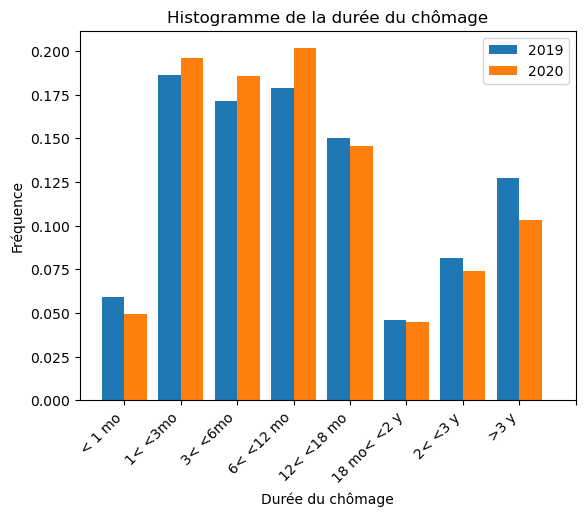

In [6]:
plt.hist([EEC_chom_2019["ANCCHOM"],EEC_chom_2020["ANCCHOM"]],bins=[i - 0.5 for i in range(1, 10)], weights = [EEC_chom_2019["EXTRIAN"],EEC_chom_2020["EXTRIAN"]], align='mid',width=0.4, density=True,label=["2019","2020"])
plt.title('Histogramme de la durée du chômage')
plt.xticks(range(1,10), ["< 1 mo","1< <3mo","3< <6mo","6< <12 mo","12< <18 mo","18 mo< <2 y","2< <3 y",">3 y",""], rotation=45, ha="right")
plt.xlabel('Durée du chômage')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

In [7]:
#Catégories possibles
categories = ["Non-renseigné", "Agriculteurs", "Artisans, commerçants, chefs d'entreprise", "Cadres et professions intellectuelles supérieures", "Professions intermédiaires", "Employés", "Ouvriers", "Inactifs ayant déjà eu une activité pro", "Chômeurs et inactifs n'ayant jamais travaillé", "NA"]
value = EEC_2019["CSTOTR"].unique()

#tableau avec CSTOR/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"CSTOTR": value, 'Effectif_emploi': [], 'Effectif_chom':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CSTOTR"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CSTOTR"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
data = pd.DataFrame(result_dict).sort_values(by="CSTOTR").reset_index(drop=True)
data

,CSTOTR,Effectif_emploi,Effectif_chom
0,0.0,120715.0,12660.0
1,1.0,403572.0,4811.0
2,2.0,1825004.0,75003.0
3,3.0,5240635.0,191348.0
4,4.0,6957339.0,345401.0
5,5.0,7291505.0,737501.0
6,6.0,5337259.0,752857.0
7,7.0,0.0,0.0
8,8.0,0.0,386600.0
9,NaN,0.0,0.0


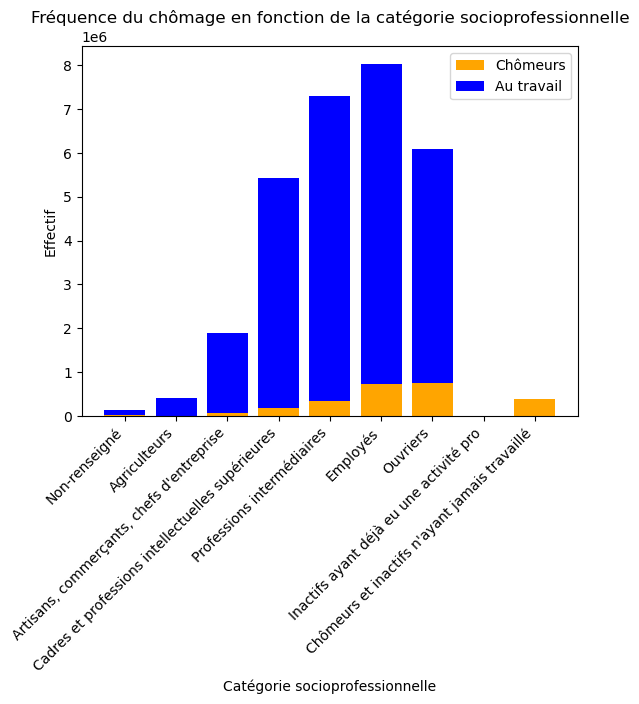

In [8]:

plt.bar(data["CSTOTR"],data["Effectif_chom"], color='orange', label='Chômeurs')
plt.bar(data["CSTOTR"],data["Effectif_emploi"], color='blue', label='Au travail', bottom=data["Effectif_chom"])
plt.title('Fréquence du chômage en fonction de la catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Effectif')
plt.xticks(data["CSTOTR"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

# Analyse en composantes principales

Variables à inclure dans la matrice de variance-covariance : ACTEU, SEXE,DIP11, type de ménages, CSTOTR, NFRRED,NBTOTE (heures travaillées usuellement) HPLUSA (nombre d'heures voulues), implication dans la recherche (CONTACT,DEM),accepterait temps partiel, ANCCHOM, AGE5, CATAU2010R ruralité, COURED ENFRED couple

## Normalisation

Variables à transformer en indicatrices (attention ne pas mettre toutes les catégories) : ACTEU DIP11, CSTOTR, NFRRED, AGE5, CATAU2010R + plus variables à régler en 0,1

Variables à normaliser : NBTOTE, HPLUSA, ANNCHOM (mettre unité)

In [9]:
#Création d'une base avec uniquement ACTEU = 1 ou 2 (en emploi ou chômeur)
EEC_PCA=EEC_2019[(EEC_2019["ACTEU"]==1) | (EEC_2019["ACTEU"]==2)]
EEC_PCA=pd.DataFrame(EEC_PCA[["EXTRIAN","ACTEU","SEXE","DIP11","CSTOTR","NFRRED","NBTOTE","HPLUSA","HHCE","CONTACT","DEM",
"ANCCHOM","AGE5","AIDFAM","CATAU2010R","COURED","ENFRED"]]).reset_index(drop=True)
EEC_PCA.head(10)

,EXTRIAN,ACTEU,SEXE,DIP11,CSTOTR,NFRRED,NBTOTE,HPLUSA,HHCE,CONTACT,DEM,ANCCHOM,AGE5,AIDFAM,CATAU2010R,COURED,ENFRED
0,46.173848,1.0,1,50.0,6.0,1.0,NaN,NaN,1.0,NaN,0.0,NaN,60,NaN,1,1,2
1,44.329298,1.0,1,50.0,6.0,1.0,NaN,NaN,1.0,NaN,0.0,NaN,60,NaN,1,1,2
2,41.532486,1.0,1,50.0,6.0,1.0,NaN,NaN,1.0,NaN,0.0,NaN,60,NaN,1,1,2
3,32.747360,1.0,1,50.0,4.0,1.0,NaN,40.0,35.0,NaN,0.0,NaN,40,NaN,1,1,1
4,32.747360,1.0,2,33.0,4.0,1.0,NaN,NaN,37.5,NaN,0.0,NaN,40,NaN,1,1,1
5,166.662079,1.0,1,10.0,4.0,3.0,NaN,NaN,37.0,NaN,0.0,NaN,15,NaN,1,2,2
6,166.662079,1.0,2,10.0,3.0,3.0,NaN,NaN,45.0,NaN,0.0,NaN,15,NaN,1,2,2
7,216.015634,1.0,1,10.0,4.0,3.0,NaN,NaN,37.0,NaN,0.0,NaN,15,NaN,1,2,2
8,216.015634,1.0,2,10.0,3.0,3.0,NaN,NaN,45.0,NaN,0.0,NaN,15,NaN,1,2,2
9,231.257688,1.0,1,10.0,4.0,3.0,NaN,NaN,37.0,NaN,0.0,NaN,15,NaN,1,2,2


In [10]:
#ACTEU
EEC_PCA.loc[EEC_PCA["ACTEU"]==1, "ACTEU_bin"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==2, "ACTEU_bin"]=1

In [11]:
#DIP11 que l'on va séparer en indicatrices pour enseignement sup, secondaire et en dessous
EEC_PCA["infcollege"]=0 #infcollege = aucun diplome, certif d'études, brevet
EEC_PCA.loc[EEC_PCA["DIP11"].isin([71,70,60]), "infcollege"]=1

EEC_PCA["secondaireplus"]=0 #secondaire plus = secondaire + BTS et DUT...
EEC_PCA.loc[EEC_PCA["DIP11"].isin([50,42,41,33,31]), "secondaireplus"]=1

EEC_PCA["sup"]=0 #le reste
EEC_PCA.loc[EEC_PCA["DIP11"].isin([30,11,10]), "sup"]=1

In [12]:
#SEXE (0 = H, 1 = F)
EEC_PCA.loc[EEC_PCA["SEXE"]==1, "SEXE_bin"]=0
EEC_PCA.loc[EEC_PCA["SEXE"]==2, "SEXE_bin"]=1

In [13]:
#CSTOTR : en se basant sur le graphique ci-dessus, je crée une catégorie employé avec les professions intermédiaires, les employés et les ouvriers
#et je crée une catégorie employeur avec les cadres sups, artisans, chef d'entreprises
EEC_PCA["employe"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([4,5,6]), "employe"]=1

EEC_PCA["employeur"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([2,3]), "employeur"]=1
#on a 3/4 de l'échantillon employe et 1/4 employeur

In [14]:
#NFRRED : variable indicatrice : "l'individu est-il de nationalité française ?"
EEC_PCA["NAT"]=0
EEC_PCA.loc[EEC_PCA["NFRRED"].isin([1,2]), "NAT"]=1
#1/20 sans nationalité FR

In [15]:
#AGE5 : transformer en deux indicatrices jeunes actifs (0 à 29 ans) ou actifs âgés (plus de 50 ans)
EEC_PCA["JEUNE"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([00,15]), "JEUNE"]=1

EEC_PCA["ANCIEN"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([50,60]), "ANCIEN"]=1
#1/5 de jeunes et 1/3 d'anciens

In [16]:
#CONTACT : contact avec pôle emploi depuis dernière enquête (3 mois), 1 si oui
EEC_PCA["P_E"]=0
EEC_PCA.loc[EEC_PCA["CONTACT"]==1, "P_E"]=1
#moins d'1/20

In [17]:
#création de metrop. 1 si l'individu habite dans un grande aire urbaine : 4/5 échantillon
EEC_PCA["METROP"]=0
EEC_PCA.loc[EEC_PCA["CATAU2010R"]==1, "METROP"]=1

In [18]:
#COURED : 1 si l'individu est en couple
EEC_PCA["COUPLE"]=0
EEC_PCA.loc[EEC_PCA["COURED"]==1, "COUPLE"]=1
#2/3 en couple

In [19]:
#ENFRED : 1 si l'individu a un enfant
EEC_PCA["ENF"]=0
EEC_PCA.loc[EEC_PCA["ENFRED"]==1, "ENF"]=1
#la moitié a un enfant

In [20]:
from sklearn.preprocessing import MinMaxScaler #pour normaliser entre 0 et 1

In [21]:
#NBTOTE
col = EEC_PCA['NBTOTE']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['NBTOTE'] = colonne_normalisee
EEC_PCA["NBTOTE"].describe()
#très peu d'entrées dans cette variable (à remédier)

count    9462.000000
mean        0.629828
std         0.230385
min         0.000000
25%         0.495798
50%         0.647059
75%         0.781513
max         1.000000
Name: NBTOTE, dtype: float64

In [22]:
#HPLUSA (beaucoup d'informations manquantes, surtout les personnes ne voulant pas modifier leur charge horraire, on va donc prendre 
#leur charge horraire actuelle comme souhait.
EEC_PCA["HHCE"]=EEC_PCA["HHCE"].fillna(0)
EEC_PCA.loc[EEC_PCA['HPLUSA'].isna(), "HPLUSA"]=EEC_PCA[EEC_PCA['HPLUSA'].isna()]["HHCE"]

In [23]:
col = EEC_PCA['HPLUSA']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['HPLUSA'] = colonne_normalisee
EEC_PCA["HPLUSA"].describe()



count    211653.000000
mean          0.343500
std           0.147048
min           0.000000
25%           0.351759
50%           0.361809
75%           0.402010
max           1.000000
Name: HPLUSA, dtype: float64

In [24]:
#ANCCHOM : recodage en mois
EEC_PCA["ANCCH"]=0.0#en emploi
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==1, "ANCCH"]=1.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==2, "ANCCH"]=2.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==3, "ANCCH"]=4.5
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==4, "ANCCH"]=9.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==5, "ANCCH"]=15.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==6, "ANCCH"]=21.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==7, "ANCCH"]=30.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==8, "ANCCH"]=40.0
EEC_PCA["ANCCH"].describe()

count    211653.000000
mean          1.337822
std           5.920752
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: ANCCH, dtype: float64

In [25]:
col = EEC_PCA['ANCCH']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['ANCCH'] = colonne_normalisee
EEC_PCA["ANCCH"].describe()

count    211653.000000
mean          0.033446
std           0.148019
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ANCCH, dtype: float64

## Matrice de covariances

In [62]:
EEC_PCA1=EEC_PCA[['HPLUSA', 'DEM', 'ACTEU_bin', 'infcollege',
       'secondaireplus', 'sup', 'SEXE_bin', 'employe', 'employeur', 'NAT',
       'JEUNE', 'ANCIEN', 'P_E', 'METROP', 'COUPLE', 'ENF', 'ANCCH']] #on omet NBTOTE pas assez d'ind.
noms_var=EEC_PCA1.columns
EEC_PCAW=EEC_PCA["EXTRIAN"].to_numpy()
EEC_PCA.head()

,EXTRIAN,NBTOTE,HPLUSA,DEM,ACTEU_bin,infcollege,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,P_E,METROP,COUPLE,ENF,ANCCH
0,46.173848,NaN,0.010050,0.0,0.0,0,1,0,0.0,1,0,1,0,1,0,1,1,0,0.0
1,44.329298,NaN,0.010050,0.0,0.0,0,1,0,0.0,1,0,1,0,1,0,1,1,0,0.0
2,41.532486,NaN,0.010050,0.0,0.0,0,1,0,0.0,1,0,1,0,1,0,1,1,0,0.0
3,32.747360,NaN,0.402010,0.0,0.0,0,1,0,0.0,1,0,1,0,0,0,1,1,1,0.0
4,32.747360,NaN,0.376884,0.0,0.0,0,1,0,1.0,1,0,1,0,0,0,1,1,1,0.0


In [63]:
EEC_COV_NP=np.cov(EEC_PCA1.to_numpy(), rowvar=False, aweights=EEC_PCAW)
EEC_COV=pd.DataFrame(EEC_COV_NP) #matrice de covariance pondérée
EEC_COV.columns = noms_var #on affiche le nom des variables correspondantes en x et y
EEC_COV.set_index(EEC_COV.columns, inplace=True)
EEC_COV

,HPLUSA,DEM,ACTEU_bin,infcollege,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,P_E,METROP,COUPLE,ENF,ANCCH
HPLUSA,0.021150,-0.026692,-0.029282,-0.007267,0.000121,0.007139,-0.010525,-0.012635,0.015064,0.002698,-0.008315,0.001202,-0.008806,-0.000211,0.010439,0.007404,-0.009834
DEM,-0.026692,0.098869,0.069533,0.009630,-0.002762,-0.006953,0.002406,0.003317,-0.012654,-0.005094,0.015078,-0.010309,0.022870,0.000787,-0.020047,-0.010953,0.023852
ACTEU_bin,-0.029282,0.069533,0.077305,0.010712,-0.002142,-0.008602,-0.000313,0.000911,-0.011883,-0.004449,0.013775,-0.006586,0.021656,0.000410,-0.018619,-0.011219,0.025964
infcollege,-0.007267,0.009630,0.010712,0.128814,-0.088159,-0.040184,-0.008399,0.020498,-0.022815,-0.015097,-0.004832,0.019640,0.003948,-0.004908,-0.005808,-0.005350,0.005254
secondaireplus,0.000121,-0.002762,-0.002142,-0.088159,0.243531,-0.153572,-0.004361,0.058078,-0.058705,0.015085,0.001322,-0.000616,0.000205,-0.014679,-0.000122,0.007034,-0.001487
sup,0.007139,-0.006953,-0.008602,-0.040184,-0.153572,0.194577,0.012963,-0.077211,0.081983,0.000097,0.002804,-0.018644,-0.004251,0.019298,0.006514,-0.001263,-0.003767
SEXE_bin,-0.010525,0.002406,-0.000313,-0.008399,-0.004361,0.012963,0.249771,0.027067,-0.024191,0.003557,-0.002626,0.001776,0.000917,0.001224,-0.003879,0.017827,-0.000276
employe,-0.012635,0.003317,0.000911,0.020498,0.058078,-0.077211,0.027067,0.200847,-0.178275,-0.001724,0.014935,-0.012907,0.003291,-0.007730,-0.013837,-0.002916,0.000077
employeur,0.015064,-0.012654,-0.011883,-0.022815,-0.058705,0.081983,-0.024191,-0.178275,0.186001,0.001832,-0.020716,0.013107,-0.004796,0.012276,0.018981,0.007600,-0.004159
NAT,0.002698,-0.005094,-0.004449,-0.015097,0.015085,0.000097,0.003557,-0.001724,0.001832,0.064232,0.003297,0.001588,-0.001832,-0.004870,-0.002190,-0.003600,-0.001787


## PCA

In [69]:
from sklearn.decomposition import PCA

# Appliquer la PCA
pca = PCA()
composantes_principales = pca.fit(EEC_COV).components_

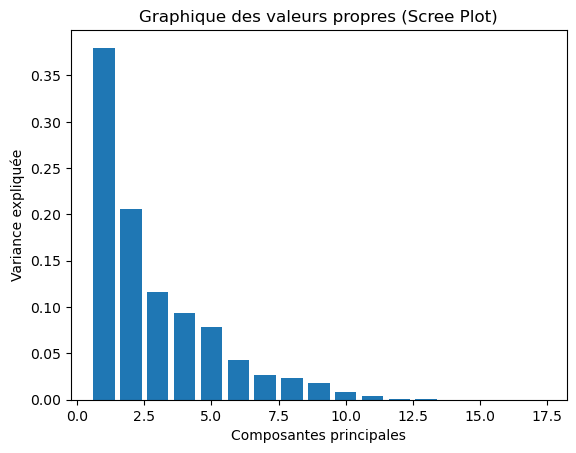

In [70]:
# Graphique des valeurs propres
valeurs_propres = pca.explained_variance_ratio_
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres)
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Graphique des valeurs propres (Scree Plot)')
plt.show()

IndexError: index 17 is out of bounds for axis 0 with size 17

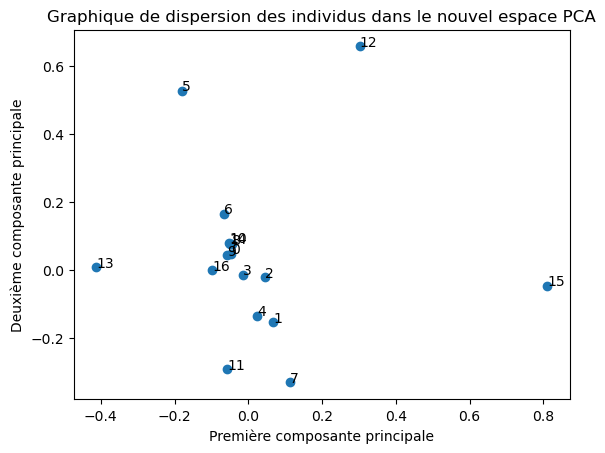

In [74]:
# Graphique de dispersion des individus dans le nouvel espace PCA
plt.scatter(composantes_principales[:, 0], composantes_principales[:, 1])
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Graphique de dispersion des individus dans le nouvel espace PCA')
for i, label in enumerate(EEC_PCA.index):
    plt.annotate(label, (composantes_principales[i, 0], composantes_principales[i, 1]))
plt.show()

# Modélisation

In [26]:
# Choisit un set de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui soit disponible sur les deux années étudiées

# Var d'interet -> ACTEU

# Var explicatives : AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# This method does not remove any observations here which indicates that there isn't any missing values in any variables
EEC_2019.dropna() 
EEC_2020.dropna() 

EEC_2019_subsample = EEC_2019.sample(n=1000, random_state=3) 



['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSTOT', 'CSTOTR', 'CSTOTPRM', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']


In [27]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array(EEC_2019_subsample.drop(columns=["ACTEU","ANNEE", "TRIM"]))
X.shape
n_features = X.shape[1]

y = np.array(EEC_2019_subsample["ACTEU"])
# convert "Chomage" in 1 and the other labels (here, "Inactif", "Actif occupé") into 1
y = np.where(y==2, 1, 0)
y.shape

# ATTENTION -> TRANSFORMATION EN ARRAY SEMBLE INTRODUIRE DES NA? PAS BCP MAIS COMPRENDRE PQ


(1000,)

## Partie I: Preparation des données

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2)

In [29]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)

print(X_test_scaled.shape)

# Identify rows with NaN values
nan_rows_train = np.isnan(X_train_scaled).any(axis=1)
# Remove rows with NaN values from both X_train_scaled and y_train
X_train_scaled = X_train_scaled[~nan_rows_train]
y_train = y_train[~nan_rows_train]

# Repeat the process for X_test_scaled and y_test
nan_rows_test = np.isnan(X_test_scaled).any(axis=1)
X_test_scaled = X_test_scaled[~nan_rows_test]
y_test = y_test[~nan_rows_test]

print(X_test_scaled.shape)

# Suppression d'un nombre très réduit d'observations

(200, 13)
(200, 13)


On normalise nos données de train car les algorithmes apprennent mieux sur ce type de données

## Partie II : Support Vector Machine

In [30]:
from sklearn.svm import SVC
#SVC est le modèle SVM permettant la classification

acc_train, acc_test = list(), list()

C_range = np.linspace(0.01, 1, 20)
for param in C_range:
    clf = SVC( C=param)
    clf.fit(X_train_scaled, y_train)
    acc_train.append(clf.score(X_train_scaled, y_train))
    acc_test.append(clf.score(X_test_scaled, y_test))


On choisit un modèle RBF car on ne connait pas la forme de la séparation dans nos données.
On entraine un premier classifieur SVM sur le jeu de données et on test plusieurs valeurs de C qui mesurent le niveau de régularisation (petites valeurs de C pour beaucoup régulariser).


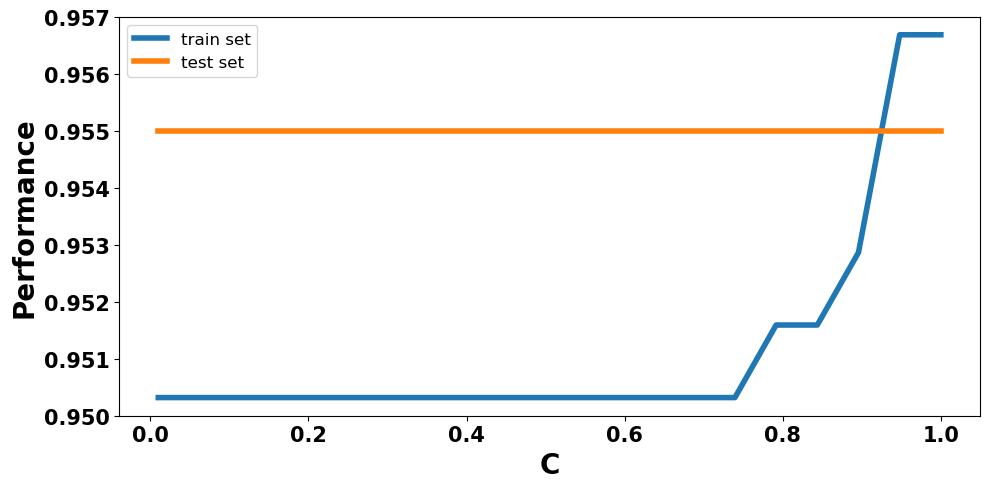

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

Le data-set compte peu de features par rapport au nombre d'observations.

Je vais essayer la régression logistique qui effectue naturellement une selection de variables. C grandit -> pas de régularisatin

 PB : Les résultats sont un peu bizarre car la performance sur le test set devrait évoluer quand C varie???


## Partie III - Regression logistique

In [32]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore", category=FutureWarning)

params= { 'C':[ 0.000001,0.001, 50]}

# j'essaie des valeurs de C très faible pour régulariser un maximum

lr =LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# On découpe notre échantillon en 5 pour la cross-validation 

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_scaled, y_train)

print(gs.best_params_)
print(gs.score(X_train_scaled, y_train))
print(gs.score(X_test_scaled, y_test))

{'C': 50}
0.9528662420382166
0.955


ATTENTION -> Best paramètre est toujours celui avec la régularisation la + forte -> ici C ~ 0 => BIZARRE

In [33]:
acc_train, acc_test = list(), list()
C_range = np.linspace(0.01, 0.1, 20)
for param in C_range:
    clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train_scaled, y_train)
    acc_train.append(clf.score(X_train_scaled, y_train))
    acc_test.append(clf.score(X_test_scaled, y_test))

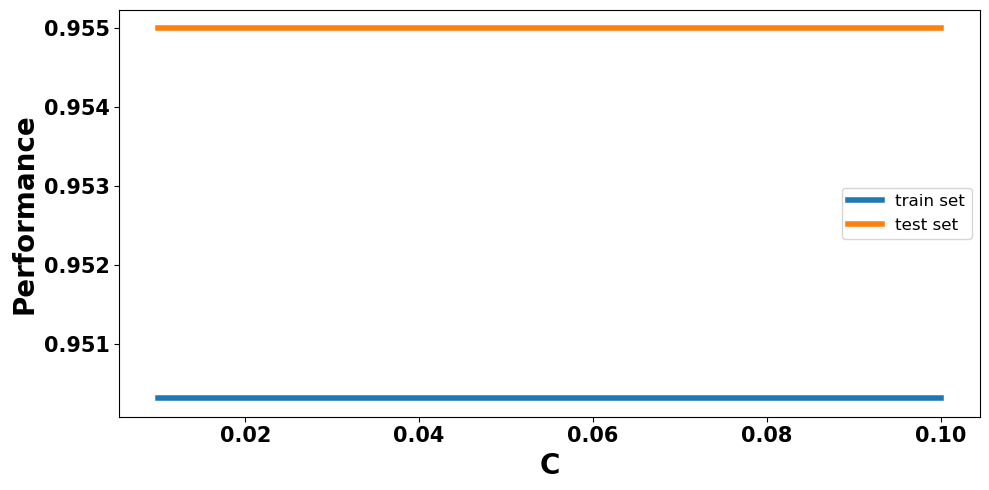

In [34]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


## Partie IV : Selections de variables

In [35]:
print(X[:100]) 

[[50. 60.  1. ...  1.  1.  3.]
 [50. 60.  1. ...  1.  2.  3.]
 [30. 40.  1. ...  1.  1.  3.]
 ...
 [15. 15.  2. ...  1.  1.  2.]
 [30. 40.  1. ...  1.  2.  4.]
 [30. 30.  1. ...  1.  1.  4.]]


In [36]:

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Identify rows with NaN values
nan_rows_train = np.isnan(X).any(axis=1)
# Remove rows with NaN values from both X_train_scaled and y_train
X_corrected = X[~nan_rows_train]
y_corrected = y[~nan_rows_train]

clf = LassoCV()

sfm = SelectFromModel(clf, threshold=None, prefit=False, norm_order=1, max_features=10)
# Je m'impose un maximum de 10 features

sfm.fit(X_corrected,y_corrected)
X_transform = sfm.transform(X_corrected)
print(X_transform.shape)

(985, 10)


Nous allons tester les performances de la regression logistique sur ce nouveau dataset

In [37]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2)

print(X_train_2.shape)

std_scale = StandardScaler().fit(X_train_2)
X_train_scaled_2 = std_scale.transform(X_train_2)
X_test_scaled_2 = std_scale.transform(X_test_2)
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
C_range = np.linspace(0.1, 5, 20)
for param in C_range:
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.001, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train_scaled_2, y_train_2)
    acc_train.append(clf.score(X_train_scaled_2, y_train_2))
    acc_test.append(clf.score(X_test_scaled_2, y_test_2))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


params= { 'C':[0.001, 1, 2], 'penalty': ['l1','l2'],'tol': [0.001,0.0001,0.1] }

# j'essaie des valeurs de C très faible pour régulariser un maximum

lr =LogisticRegression( dual=False, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# On découpe notre échantillon en 3 pour la cross-validation (je pense qu'on peut difficilement faire plus car
# nous ne possédons que 542 observations)

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=3)

gs.fit(X_train_scaled_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_scaled_2, y_train_2))
print(gs.score(X_test_scaled_2, y_test_2))


ValueError: Found input variables with inconsistent numbers of samples: [985, 1000]

Score baisse quand on impose un nombre fini de variables dans le modèle